In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode
%matplotlib inline

In [2]:
c = [10., 1.]

ffb = 0

def fun(t, x, m, k1, k2):
  g = 9.8 # metres per second

  v = x[1]
  a = -((k1*x[0])/m) + -((k2*x[1])/m)
  
  # Add gravity
  a += g
  
  # Add disturbance
  a += 0.5*np.sin(10*t)
  
  # Add sliding mode control input
  a -= 20*ffb
  
  xdot = [v, a]

  # return the state derivatives
  return xdot

In [3]:
# Create an `ode` instance to solve the system of differential
# equations defined by `fun`, and set the solver method to 'dop853'.
solver = ode(fun)
solver.set_integrator('dopri5')

# Give the value of omega to the solver. This is passed to
# `fun` when the solver calls it.
solver.set_f_params(0.1,2.5,0.1)

# Set the initial value z(0) = z0.
t0 = 0.0
z0 = [-1., 0.]
solver.set_initial_value(z0, t0)

# Create the array `t` of time values at which to compute
# the solution, and create an array to hold the solution.
# Put the initial value in the solution array.
t1 = 10.
N = 50000
t = np.linspace(t0, t1, N)
sol = np.empty((N, 2))
sol[0] = z0
sigma = np.empty((N, 1))

# Repeatedly call the `integrate` method to advance the
# solution to time t[k], and save the solution in sol[k].
k = 1
while solver.successful() and solver.t < t1:
    solver.integrate(t[k])
    sol[k] = solver.y

    sigma[k] = c[0]*sol[k][0] + c[1]*sol[k][1]

    if sigma[k] > 0.:
        ffb = 1.
    else:
        ffb = -1.

    k += 1

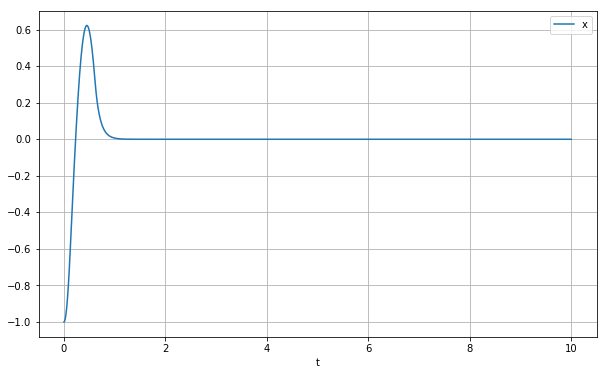

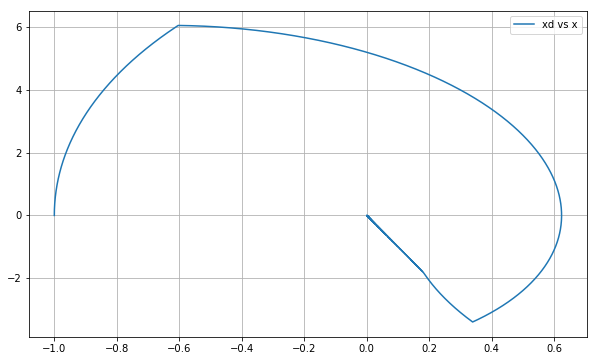

In [4]:
# Plot the solution...
fig0 = plt.figure(0, figsize=(10,6))
plt.plot(t, sol[:,0], label='x')
#plt.plot(t, sol[:,1], label='xd')
#plt.plot(t, sigma, label='sig')
plt.xlabel('t')
plt.grid(True)
plt.legend()
fig0 = plt.figure(1, figsize=(10,6))
plt.plot(sol[:,0], sol[:,1], label='xd vs x')
plt.grid(True)
plt.legend()
plt.show()